In [1]:
import numpy as np
#import pylab as plt
import datetime
import pandas as pd
import xarray as xr
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
def smapi_count(ts,sm_mean):
    if np.isnan(ts).all() == True:
        med_smapi = np.empty((len(ts),)) * np.nan
        smapi = med_smapi
        return smapi
    else:
#     med_ds = xr_ds['svw1_mean']
#     ts = med_ds[:,lat_tick,lon_tick].values
    # This func returns the ESSMI and Probability corresponding to each soil moisture value
    
    # ts represents the data time series at single pixel

    # log transform for ds, for matching the requirement of KDE
#         ts_in = np.log(ts) - np.log(1 - ts)
#         kde = sm.nonparametric.KDEUnivariate(ts_in)
#         kde.fit(kernel='gau', bw='normal_reference', fft=True, weights=None, gridsize=None)  # Estimate the densities
#         kde_cdf = kde.cdf
#         essmi_fit = stats.norm.ppf(kde.cdf, loc=0, scale=1)
#         cdf_x = np.exp(kde.support) / (1 + np.exp(kde.support))
#         # estimate the soil moisture-based PDF by using KDE
#         kde_pdf = kde.evaluate(ts_in)
        # retrieve essmi from essmi-probability curve
        smapi = (ts-sm_mean)/sm_mean
        return smapi

In [3]:
from tqdm.notebook import tqdm
ds = xr.open_dataset(r'G:\ERA5_Land_surface-HRB\swvl1_weekly_HRB_from_1980_to_2021.nc')
data = ds['swvl1'].values
data_surf = np.reshape(data,[2140,-1])
sm_mean = np.nanmean(data_surf[:])
smapi_ds = np.copy(data)*np.nan
for ii in tqdm(range(data.shape[1])):
    for jj in range(data.shape[2]):
        med_ts = data[:,ii,jj]
        smapi_ds[:,ii,jj] = smapi_count(med_ts,sm_mean)
        #print(ii,jj)

  0%|          | 0/64 [00:00<?, ?it/s]

In [5]:
# Save kde and essmi as xarray to netCDF4
lat = ds.lat.values[:,1]
lon = ds.lon.values[1,:]

out = xr.Dataset({'smapi': (['time', 'lat', 'lon'], smapi_ds)},
                 coords={'lat': (['lat'], lat),
                         'lon': (['lon'], lon),
                         'time': pd.date_range('1979-12-31', periods=2140, freq='W').strftime('%Y-%m-%d')})
#pd.period_range('2010-01', periods=data.shape[0], freq='M')})

out.to_netcdf(r'G:\ESSMI_TEST\HRB_weekly_SMAPI.nc')

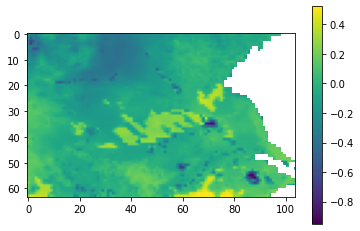

In [4]:
plt.imshow(smapi_ds[48,:,:])
plt.colorbar()

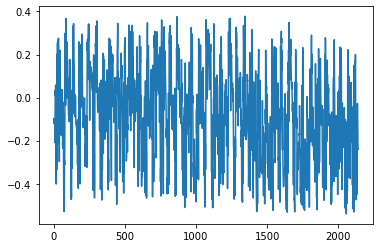

In [6]:
plt.plot(smapi_ds[:,15,14])

In [19]:
# Classification for ESSMI
# >=2 extreme wet
# 1.5 ~ 2.0 Sever wet
# 1.0 ~ 1.5 Moderate wet
# -1.0 ~ 1.0 Near Normal
# -1.5 ~ -1.0 Moderate dry
# -2.0 ~ -1.5 Serve dry
# <= -2.0 Extreme dry
# essmi_level 
essmi_class = essmi_ds.copy()
essmi_class[essmi_ds >= 2] = 3
essmi_class[(essmi_ds >= 1.5) & (essmi_ds < 2)] = 2
essmi_class[(essmi_ds >= 1) & (essmi_ds < 1.5)] = 1
essmi_class[(essmi_ds > -1) & (essmi_ds <= 1)] = 0
essmi_class[(essmi_ds > -1.5) & (essmi_ds <= -1)] = -1
essmi_class[(essmi_ds > -2) & (essmi_ds <= -1.5)] = -2
essmi_class[essmi_ds <= -2] = -3

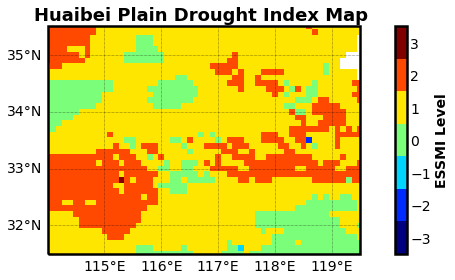

In [27]:
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
# import matplotlib.cm as cm
# from matplotlib.colors import BoundaryNorm
# from matplotlib.ticker import MaxNLocator
#
dt = essmi_class[30,:,:]
fig = plt.figure(figsize=(10, 4))
plt.rcParams['axes.linewidth'] = 2.5
ax = plt.subplot(projection=ccrs.PlateCarree())
plt.title("Huaibei Plain Drought Index Map ", fontsize=18, weight='bold')

#levels = MaxNLocator(nbins=7).tick_values(-3.5, 3.5)
cmap = plt.get_cmap('jet',7)
dtplot = plt.pcolormesh(ds.lon.values,ds.lat.values,dt,cmap=cmap)
plt.clim(-3.5, 3.5)
# cmap = cm.get_cmap("jet",lut=7)
# dtplot = ax.pcolormesh(data.lon.values,data.lat.values,dt,cmap=cmap,vmin=-3.5,vmax=3.5)#,vmin=-3, vmax=3)
# cbar = plt.colorbar(dtplot, extend='both')
#cbar.ax.set_xticklabels(np.arange(-3,3,1))  # horizontal colorbar
cbar = plt.colorbar(dtplot, ticks=np.arange(-3,3.2,1), label='Change in user population')
cbar.ax.axes.tick_params(length=0)
cbar.set_label(label='ESSMI Level', size = 14, weight='bold')
cbar.ax.tick_params(labelsize=14)
#outline_spain.plot(ax = ax, alpha = 1, facecolor = 'none')
#ax.add_feature(cf.COASTLINE.with_scale('110m'),lw=0.4)
#ax.add_feature(cf.RIVERS.with_scale('110m'),lw=0.4)
ax.set_aspect('equal')
gl=ax.gridlines(draw_labels=True,linestyle=":",linewidth=0.5,color='k')
gl.top_labels=False #关闭上部经纬标签                                  
gl.right_labels=False
#gl.xlocator = mticker.FixedLocator([120, 140, 160, 180, -160, -140, -120])
gl.ylocator = mticker.FixedLocator(np.arange(31,35.5,1))
gl.xformatter = LONGITUDE_FORMATTER  #使横坐标转化为经纬度格式            
gl.yformatter = LATITUDE_FORMATTER  
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
plt.axis([114,119.5,31.5,35.5])
plt.tight_layout()
#plt.savefig(r'G:\ESSMI_TEST\ESSMI_classification_map_sample.png',dpi=300)

In [29]:
# Save kde and essmi as xarray to netCDF4
lat = ds.lat.values[:,1]
lon = ds.lon.values[1,:]

out = xr.Dataset({'essmi_class': (['time', 'lat', 'lon'], essmi_class)},
                 coords={'lat': (['lat'], lat),
                         'lon': (['lon'], lon),
                         'time': pd.date_range('1979-12-31', periods=2140, freq='W').strftime('%Y-%m No.%V')})
#pd.period_range('2010-01', periods=data.shape[0], freq='M')})

out.to_netcdf(r'G:\ESSMI_TEST\huaibei_plain_weekly_ESSMI_class.nc')